In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# (a) create the train and validation data

alpha = 10000

series = np.random.randint(0, 10, (alpha, 30))
sums = np.sum(series, axis=1)
labels = (sums >= 100).astype(int)

series_train, series_val, labels_train, labels_val = train_test_split(series, labels, test_size=0.2, random_state=42)

# print(series_train.shape) => (8000, 30)
# print(series_val.shape) => (2000, 30)
# print(labels_train.shape) => (8000,)
# print(labels_val.shape) => (2000,)

In [ ]:
# numpy array to tensor
X_train = torch.tensor(series_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(series_val, dtype=torch.float32).unsqueeze(-1)

Y_train = torch.tensor(labels_train, dtype=torch.float32).unsqueeze(-1)
Y_val = torch.tensor(labels_val, dtype=torch.float32).unsqueeze(-1)

# datasets, dataloaders
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

mini_batch = 50
train_loader = DataLoader(train_dataset, batch_size=mini_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_dataset.__len__(), shuffle=False)

In [17]:
# train & evaluate loop

def eval_loop(model, data_loader, device):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for numbers, labels in data_loader:
      numbers, labels = numbers.to(device), labels.to(device)
      outputs = model(numbers)
      pred = (outputs > 0.5).float()
      correct += (pred == labels).sum().item()
      total += labels.size(0)

  return correct / total

def train_loop(model, train_loader, val_loader, optimizer, loss_fn, epochs, device):
  model.to(device)
  model.train()

  train_accs = []
  val_accs = []

  for epoch in range(1, epochs+1):
    running_loss = 0.0
    for numbers, labels in train_loader:
      numbers, labels = numbers.to(device), labels.to(device)
      outputs = model(numbers)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    percent = (epoch / epochs) * 100
    train_acc = eval_loop(model, train_loader, device)
    val_acc = eval_loop(model, val_loader, device)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch}/{epochs} ({percent:.1f}%): Loss: {avg_loss:.3f} Train Acc = {train_acc:.4f}, Val acc = {val_acc:.4f}")

  return train_accs, val_accs

In [35]:
# (b)

class LSTMClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm_cells = 200
    self.lstm = nn.LSTM(input_size=1, hidden_size=self.lstm_cells, batch_first=True)
    self.fc1 = nn.Linear(self.lstm_cells, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    last_step = lstm_out[:, -1, :]
    output  = self.fc1(last_step)
    prod = self.sigmoid(output)

    return prod

In [ ]:
# (c)

# train the model with 60 epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCELoss()
model = LSTMClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
train_accs, val_accs = train_loop(model, train_loader, val_loader, optimizer, loss_fn, epochs=60, device=device)

Epoch 1/60 (1.7%): Loss: 0.084 Train Acc = 0.9886, Val acc = 0.9880
Epoch 2/60 (3.3%): Loss: 0.063 Train Acc = 0.9886, Val acc = 0.9880
Epoch 3/60 (5.0%): Loss: 0.063 Train Acc = 0.9886, Val acc = 0.9880
Epoch 4/60 (6.7%): Loss: 0.062 Train Acc = 0.9886, Val acc = 0.9880
Epoch 5/60 (8.3%): Loss: 0.062 Train Acc = 0.9886, Val acc = 0.9880
Epoch 6/60 (10.0%): Loss: 0.062 Train Acc = 0.9886, Val acc = 0.9880
Epoch 7/60 (11.7%): Loss: 0.061 Train Acc = 0.9886, Val acc = 0.9880
Epoch 8/60 (13.3%): Loss: 0.060 Train Acc = 0.9886, Val acc = 0.9880
Epoch 9/60 (15.0%): Loss: 0.060 Train Acc = 0.9886, Val acc = 0.9880
Epoch 10/60 (16.7%): Loss: 0.053 Train Acc = 0.9886, Val acc = 0.9880
Epoch 11/60 (18.3%): Loss: 0.056 Train Acc = 0.9886, Val acc = 0.9880
Epoch 12/60 (20.0%): Loss: 0.040 Train Acc = 0.9886, Val acc = 0.9880
Epoch 13/60 (21.7%): Loss: 0.055 Train Acc = 0.9886, Val acc = 0.9880
Epoch 14/60 (23.3%): Loss: 0.033 Train Acc = 0.9886, Val acc = 0.9880
Epoch 15/60 (25.0%): Loss: 0.020 T

In [38]:
# final result

final_val_acc = val_accs[-1]
print(f"Final accuracy on the validation data: {final_val_acc:.4f}")

class_1 = (labels == 1).sum()
class_0 = (labels == 0).sum()
print(f"Class 1: {class_1}, Class 0: {class_0}")

print("""The class distribution is highly imbalanced, since class 1 (sum >= 100) has 9885 examples,
while class 0 (sum <= 100) has 115 examples.
The model achieves 98.8% of accuracy predicting only class 1.""")

Final accuracy on the validation data: 0.9960
Class 1: 9885, Class 0: 115
The class distribution is highly imbalanced, since class 1 (sum >= 100) has 9885 examples,
while class 0 (sum <= 100) has 115 examples.
The model achieves 98.8% of accuracy predicting only class 1.


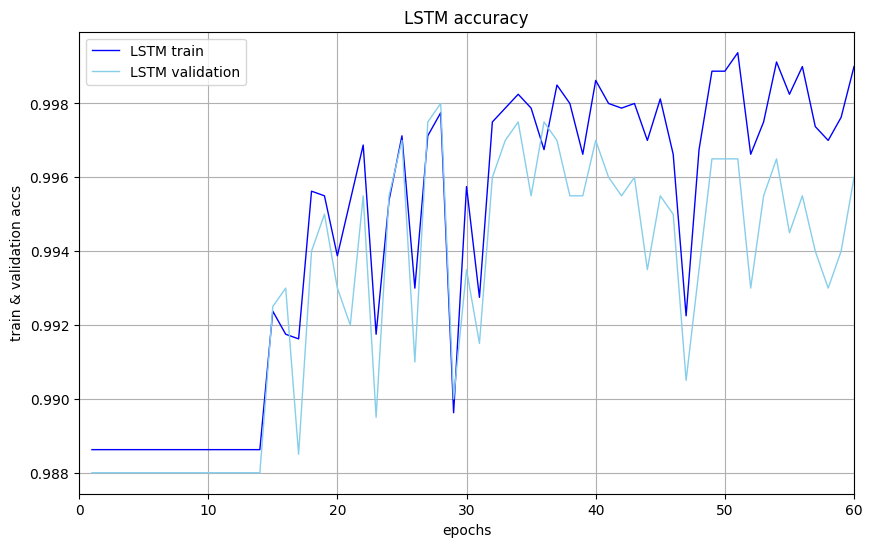

In [23]:
# plot accuracy vs. epochs

epochs = range(1, len(train_accs)+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label='LSTM train', color='blue', linewidth=1.0)
plt.plot(epochs, val_accs, label='LSTM validation', color='skyblue', linewidth=1.0)

plt.xlim(0, 60)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('LSTM accuracy')
plt.legend()
plt.grid(True)
plt.show()